# Data

In [14]:
import pandas as pd
import re
from datetime import datetime

# data from http://www.brucehardie.com/datasets
data_path = "CDNOW_master.txt"

orders_list = []
with open(data_path) as f:
    for line in f:
        inner_list = [line.strip() for line in re.split('\s+', line.strip())]
        orders_list.append(inner_list)

orders = pd.DataFrame(orders_list, columns = ["id", "date", "orders", "spend"])

orders["date"] = pd.to_datetime(orders["date"])
orders["spend"] = orders["spend"].astype(float)
orders = orders[orders["spend"] > 0]
orders.head()

,id,date,orders,spend
0,00001,1997-01-01,1,11.77
1,00002,1997-01-12,1,12.00
2,00002,1997-01-12,5,77.00
3,00003,1997-01-02,2,20.76
4,00003,1997-03-30,2,20.76


# Analytic aggregate

In [2]:
from datetime import timedelta
from numpy import ceil, maximum

churned_after = timedelta(weeks = 12)
end_date = orders["date"].max()

group_by_customer = orders.groupby(by = orders["id"], as_index = False)
customers = group_by_customer["date"].agg(lambda x: (x.max() - x.min()))
customers["age"] = maximum(customers["date"].apply(lambda x: ceil(x.days/30)),1.0)
customers = customers.drop(columns = "date")
customers.head()

,id,age
0,00001,1.0
1,00002,1.0
2,00003,18.0
3,00004,12.0
4,00005,13.0


In [3]:
lost = group_by_customer["date"].max()["date"].apply(lambda x: (end_date - x) > churned_after).sum()
churn = lost / customers["age"].sum()
spend = orders["spend"].sum() / customers["age"].sum()
clv_aa = spend/churn 
print(clv_aa)

123.04702903543307


# Analytic by cohort

In [4]:
customers_ac = customers.merge(group_by_customer["spend"].sum(), on = "id")
customers_ac["clv"] = customers_ac["spend"] / customers_ac["age"] / churn
customers_ac.head()

,id,age,spend,clv
0,00001,1.0,11.77,71.642924
1,00002,1.0,89.00,541.734941
2,00003,18.0,156.46,52.908770
3,00004,12.0,100.50,50.977867
4,00005,13.0,385.61,180.551781


In [5]:
clv_ac = customers_ac["clv"]
print(clv_ac.mean()) # $172.95
print(clv_ac.median())

174.65943598301126
105.66874803149607


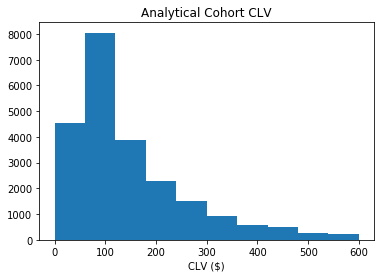

In [15]:
from matplotlib import pyplot as plt

plt.hist(clv_ac, range = (0, 600))
plt.title("Analytical Cohort CLV")
plt.xlabel("CLV ($)")
plt.savefig("clv_cohort_hist.png", dpi = 300, bbox_inches = "tight")
plt.show()

# Predictive CLV model

In [16]:
from lifetimes.utils import summary_data_from_transaction_data

data = summary_data_from_transaction_data(
    orders, 'id', 'date', 
    monetary_value_col='spend', observation_period_end = end_date)
data.head()

,frequency,recency,T,monetary_value
id,,,,
00001,0.0,0.0,545.0,0.000000
00002,0.0,0.0,534.0,0.000000
00003,5.0,511.0,544.0,27.140000
00004,3.0,345.0,545.0,23.723333
00005,10.0,367.0,545.0,35.628000


In [17]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])

<lifetimes.BetaGeoFitter: fitted with 23502 subjects, a: 0.48, alpha: 41.99, b: 2.11, r: 0.27>

In [9]:
future_horizon = 10000
data['predicted_purchases'] = bgf.predict(future_horizon, data['frequency'], data['recency'], data['T'])
data.head()

,frequency,recency,T,monetary_value,predicted_purchases
id,,,,,
00001,0.0,0.0,545.0,0.000000,2.474814
00002,0.0,0.0,534.0,0.000000,2.508305
00003,5.0,511.0,544.0,27.140000,34.399505
00004,3.0,345.0,545.0,23.723333,16.742080
00005,10.0,367.0,545.0,35.628000,25.828239


In [10]:
from lifetimes import GammaGammaFitter

returning_customers_summary = data[data['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(
    returning_customers_summary['frequency'],
    returning_customers_summary['monetary_value'])
transaction_spend = ggf.conditional_expected_average_profit(data['frequency'], data['monetary_value']).mean()
print(transaction_spend)

36.177876991661236


In [11]:
customers_pm = customers_ac.join(data["predicted_purchases"], on = "id", how = "left").drop(columns = "clv")
customers_pm["clv"] = customers_pm.apply(lambda x: x["predicted_purchases"] * transaction_spend, axis = 1)
customers_pm.tail()

,id,age,spend,predicted_purchases,clv
23497,23566,1.0,36.00,2.756070,99.708756
23498,23567,1.0,20.97,2.756070,99.708756
23499,23568,1.0,121.70,1.315359,47.586905
23500,23569,1.0,25.74,2.756070,99.708756
23501,23570,1.0,94.08,1.847175,66.826865


In [12]:
clv_pm = customers_pm["clv"]
print(clv_pm.mean())
print(clv_pm.median())

424.09105292581245
97.80953937859441


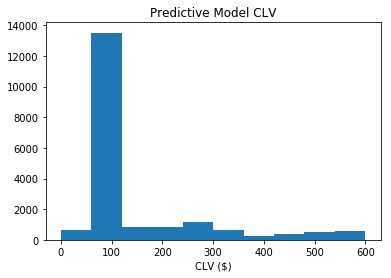

In [13]:
plt.hist(clv_pm, range = (0,600))
plt.title("Predictive Model CLV")
plt.xlabel("CLV ($)")
plt.savefig("clv_bgf_hist.png", dpi = 300, bbox_inches = "tight")
plt.show()